In [1]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

import meshplot as mp
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from src import shapes

# Define The Figure and the Morse Function

In [2]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)

In [3]:
f = lambda p: np.linalg.norm(p, axis=-1, ord=2)
f_linear = lambda p: p[:, 1]
#f = lambda p: (np.random.random(3)*p).sum(axis=-1)*(np.random.random(3)*p).sum(axis=-1)

In [4]:
def cylindrical_twist(vertices, k=1.0, mode="x", scale=1.0):
    """
    Nonlinear cylindrical twist diffeomorphism on R^3.

    vertices: (n,3) array
    mode:
      - "z": angle depends on z  (theta = k * tanh(z/scale))
      - "r": angle depends on radius r (theta = k * tanh(r/scale))
    k: twist strength (radians, roughly bounded by +/-k for tanh)
    scale: controls how quickly tanh saturates
    """
    if mode == 'x':
        v = vertices[:, [1, 2, 0]]
        v = cylindrical_twist(v, k=k, mode="z", scale=scale)
        v = v[:, [2, 0, 1]]
        return v
        
        
    v = vertices.copy()
    x, y, z = v[:, 0], v[:, 1], v[:, 2]

    r = np.sqrt(x*x + y*y)

    if mode == "z":
        theta = k * np.tanh(z / scale)
    elif mode == "r":
        theta = k * np.tanh(r / scale)
    else:
        raise ValueError('mode must be "z" or "r"')

    c, s = np.cos(theta), np.sin(theta)

    v[:, 0] = c * x - s * y
    v[:, 1] = s * x + c * y
    
    return v

In [5]:
n, m = 13, 12
vertices, faces = shapes.get_halftori_bouquet(leaves=3, n=n, m=m, l0=0.9, glue=False)

vertices = cylindrical_twist(vertices, k=-0.3, scale=1.5, mode='x')

vertices, faces = shapes.split_large_edges(vertices, faces, max_length=1.0)


print(f'faces.shape = {faces.shape}')

face_mean_values = f_linear(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_mean_values, shading={"wireframe": True})

faces.shape = (1282, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.70…

In [6]:
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3, dtype=faces.dtype), faces]).ravel()

mesh = pv.PolyData(vertices, faces_pv)
mesh.point_data["values"] = f_linear(vertices)  # per-vertex scalars

p = pv.Plotter(window_size=(600, 600))
p.add_mesh(
    mesh,
    scalars="values",
    cmap="viridis",
    smooth_shading=False,   # helps show linear interpolation nicely
    show_edges=True,      # set True if you want to see triangle edges
)
p.add_scalar_bar(title="values")
p.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf79048b230_0&reconnect=auto" class="pyvi…

# Paths

In [7]:
from src.ms import MorseSmale

In [8]:
ms = MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
#ms = MorseSmale(faces, f(vertices), vertices, forest_method='spaning')
ms = MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')

paths = list(ms.iterate_paths())

In [9]:
from src import vis
from src.vis import plot_paths, plot_segmentation_forests, plot_ms_comparition


In [10]:
pl = plot_paths(ms)
pl.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf77c3da5d0_1&reconnect=auto" class="pyvi…

In [11]:
pl = plot_segmentation_forests(ms, plot_complex=True,  point_size=16)
pl.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf77c3da000_2&reconnect=auto" class="pyvi…

In [12]:
ms0 =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
ms1 =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')

ms0.define_critical_points()
ms1.define_critical_points()

In [13]:
pl = plot_ms_comparition([ms0, ms1], plot_segmentation_forests=False)
pl.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf77c348410_3&reconnect=auto" class="pyvi…

# Simplification

In [14]:
#ms =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')
ms =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')

In [15]:
faces_components = ms.define_decomposition_by_paths()
pd.Series(faces_components).value_counts().sort_index()

0     104
1     106
2     107
3     107
4      68
5      85
6      39
7      22
8     109
9     104
10    109
11    108
12     22
13     39
14     85
15     68
Name: count, dtype: int64

In [16]:
new_mesh = vis.get_pv_mesh(ms.vertices, ms.faces)
new_mesh.cell_data['component'] = ms.define_decomposition_by_paths()


pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, scalars="component", cmap="rainbow", smooth_shading=False, show_edges=True, categories=True)
for path in ms.get_paths():
    pl.add_mesh(pv.lines_from_points(vertices[path]), color='white', line_width=4)

pl.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf77c2a4710_4&reconnect=auto" class="pyvi…

In [17]:
chain = ms.get_paths()[0]

new_mesh = vis.get_pv_mesh(ms.vertices, ms.faces)
new_mesh.cell_data['distance from chain'] = ms.get_face_distances_from_chain(chain)


pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, scalars="distance from chain", cmap="turbo", smooth_shading=False, show_edges=True, categories=True)
pl.add_mesh(pv.lines_from_points(vertices[chain]), color='orangered', line_width=4)

pl.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf79056ee10_5&reconnect=auto" class="pyvi…

In [18]:
crytical_type_colors_dict = {'min': 'lime', 'max': 'red', 'saddle': 'yellow', 'regular': 'lightgrey'}

In [19]:
import time

Computed geodesics without simplification in 9.1838 seconds.
Computed geodesics with simplification in 6.4719 seconds.


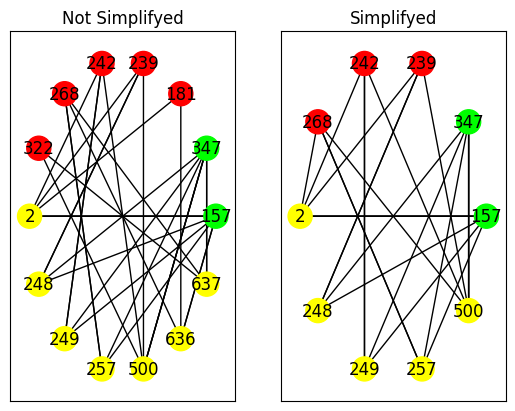

In [36]:
max_distance = np.inf

timer = time.perf_counter()
geodesics_graph0 = ms.get_geodesics_graph(simplify=False, max_distance=max_distance)
print(f'Computed geodesics without simplification in {time.perf_counter() - timer:.4f} seconds.')

timer = time.perf_counter()
geodesics_graph1 = ms.get_geodesics_graph(simplify=True, max_distance=max_distance)
print(f'Computed geodesics with simplification in {time.perf_counter() - timer:.4f} seconds.')

pos0 = nx.circular_layout(geodesics_graph0)
pos1 = nx.circular_layout(geodesics_graph1)
node_colors0 = pd.DataFrame([data for node, data in geodesics_graph0.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values
node_colors1 = pd.DataFrame([data for node, data in geodesics_graph1.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values

fig, axs = plt.subplots(1, 2)
axs[0].set_title('Not Simplifyed')
axs[1].set_title('Simplifyed')
nx.draw_networkx(geodesics_graph0, pos=pos0, node_color=node_colors0, ax=axs[0])
nx.draw_networkx(geodesics_graph1, pos=pos1, node_color=node_colors1, ax=axs[1])
plt.show()

In [37]:
pl = pv.Plotter(shape=(2, 2), window_size=(1000, 800))

for i_row, (title, graph) in enumerate(zip(['not simplifyed', 'simplifyed'], [geodesics_graph0, geodesics_graph1])):
    for i_col, path_attr in enumerate(['path', 'geopath']):
        pl.subplot(i_col, i_row)

        pl.add_text(f'{title} {path_attr}s')

        pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, opacity=0.4)

        for critical_type, color in crytical_type_colors_dict.items():
            pts = ms.vertices[[node for node, data in graph.nodes(data=True) if critical_type == data['critical_type']]]
            if len(pts) > 0:
                pl.add_mesh(pts, color=color, point_size=12, render_points_as_spheres=True)

        for e0, e1, data in graph.edges(data=True):
            pts = data[path_attr]
            if pts.ndim == 1:
                pts = ms.vertices[pts]
            pl.add_mesh(pv.lines_from_points(pts), color='midnightblue', line_width=4)

pl.link_views()
pl.show()

Widget(value='<iframe src="http://localhost:34907/index.html?ui=P_0x7cf60005e480_18&reconnect=auto" class="pyv…